# Exploration

In this notebook we explore different aspects of the given earthquake data.

### Preliminaries

Import the required dependencies.

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from src.features import build_features
# from src.data import make_dataset 
# commented out because: there seems to be an issue at the moment with the initial method from make_dataset
from src.models import train_model
from src.models import predict_model
from src.visualization import visualize

Load the data.

In [3]:
train_df = pd.read_csv('../data/raw/train_values.csv')
target_df = pd.read_csv('../data/raw/train_labels.csv')

### General Properties

In [4]:
# Lets get a first overview about the dataset 
pd.options.display.max_columns = None
train_df.head(10)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
5,333020,8,558,6089,2,10,9,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
6,728451,9,475,12066,2,25,3,4,n,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
7,475515,20,323,12236,2,0,8,6,t,w,q,v,x,s,u,0,0,0,0,0,1,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
8,441126,0,757,7219,2,15,8,6,t,r,q,f,q,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
9,989500,26,886,994,1,0,13,4,t,i,n,v,j,s,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


### Feature Description
In the following the features of the dataset are described. This is done by evaluating the name, datatype and values of the feature to try to predict its usage. Deeper analysis for each feature is further described after the following list:

1. `building_id` which seems to be used to identify each unique building.
2. `geo_level_1_id`, `geo_level_2_id`, `geo_level_3_id` (unkown)
3. `count_floors_pre_eq` seems to be the number of floors the building had before the earthquake happend
4. `age` seems to be the age of the building before it was destroyed
5. `area_percentage` maybe the amount of buildings in an area 
6. `height_percentage` likely the height of the building before it was destroyed
7. `land_surface_condition` likely the condition the surface of the ground of the building had before the earthquake
8. `foundation_type` as the name suggests this seems to be the type of the foundation the building was built 
9. `roof_type`, `ground_floor_type`, `other_floor_type` as the name suggest this seems to be the type of the roof and floors the building had. It seems like only to types of floors where recorded
10. `position` (unkown)
11. `plan_configuration` (unkown)
12. `has_superstructure..` likely a one hot encoded feature that represents the type of the superstructure
13. `legal_ownership_status`
14. `count_families` seems to be the amount of families that lived in the building
15. `has_secondary_use` seems to be a flag that







#### analysis for `building_id`

This feature describes each unique building that was recorded in the dataset. As the data shows, a total of 260.601 (about a quarter of a million) buildings where recorded in this dataset

In [5]:
train_df.building_id.count()

260601

<b>analysis for `count_floors_pre_eq`</b>

The "count_floors_pre_eq" feature represents the number of floors in the building before the earthquake, and its possible values are integers from 1 to 9. The data is showing that most buildings had a height of 2 to 3 floors. The maximum size of a building has 9 floors.

In [6]:
train_df.count_floors_pre_eq.value_counts()

count_floors_pre_eq
2    156623
3     55617
1     40441
4      5424
5      2246
6       209
7        39
8         1
9         1
Name: count, dtype: int64

<b>analysis for `age`</b>
As the analysis below shows, the age feature is unbalanced with the age of the buildings going up to the maximum of age 995. However most buildings have an age below 100

In [7]:
# lets see what the max value is
train_df.age.max()

995

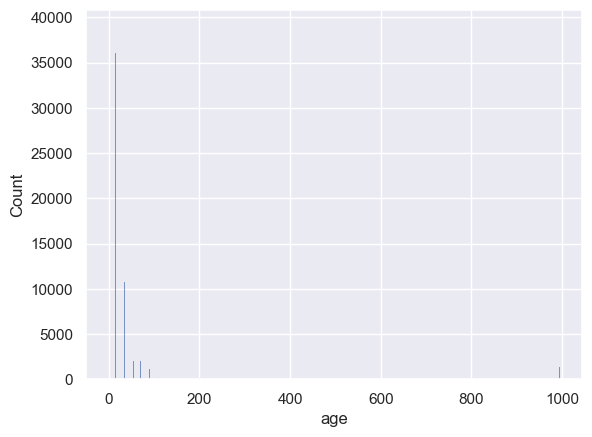

In [8]:
# Lets take a first look at the distribution
sns.set(style="darkgrid")
sns.histplot(train_df, x="age")
plt.show()

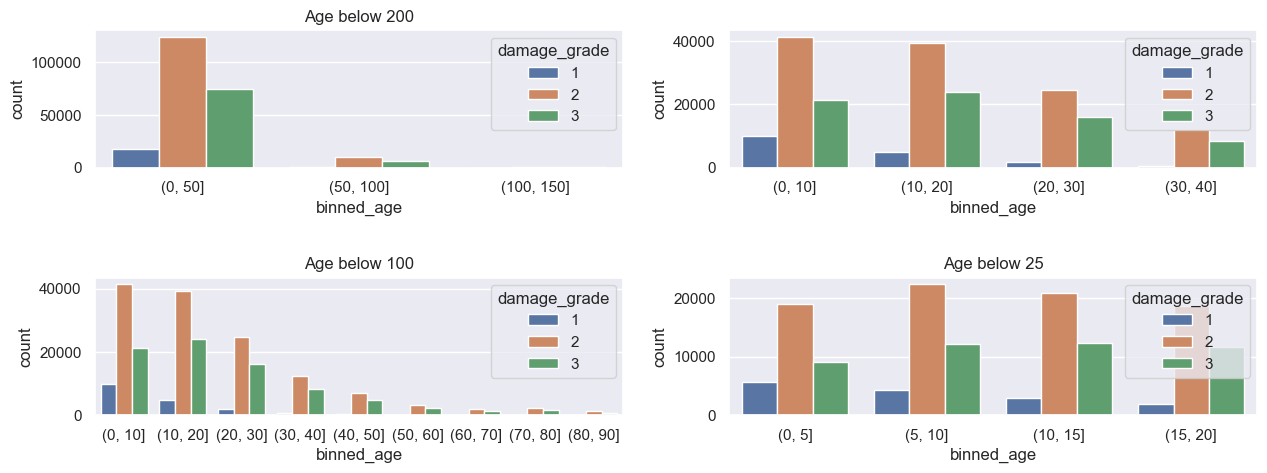

In [56]:
# as the graph shows most buildings are below the age of 200
# lets remove outliers and create a new graph

# merge the two dataframes on building_id
merged_df = pd.merge(train_df, target_df, on='building_id')

threshold1 = 200
threshold2 = 100
threshold3 = 50
threshold4 = 25

temp_df1 = merged_df.copy()
temp_df2 = merged_df.copy()
temp_df3 = merged_df.copy()
temp_df4 = merged_df.copy()

temp_df1["binned_age"] = pd.cut(merged_df['age'], bins=list(range(0,threshold1,50)))
temp_df2["binned_age"] = pd.cut(merged_df['age'], bins=list(range(0,threshold2,10)))
temp_df3["binned_age"] = pd.cut(merged_df['age'], bins=list(range(0,threshold3,10)))
temp_df4["binned_age"] = pd.cut(merged_df['age'], bins=list(range(0,threshold4,5)))

# Create a figure with 2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 5))
# set the vertical spacing between the subplots
plt.subplots_adjust(hspace=0.8)

# Plot the first graph in the first subplot
sns.countplot(data=temp_df1, x='binned_age', hue='damage_grade', ax=axs[0][0])
axs[0][0].set_title(f'Age below {threshold1}')

# Plot the second graph in the second subplot
sns.countplot(data=temp_df2, x='binned_age', hue='damage_grade', ax=axs[1][0])
axs[1][0].set_title(f'Age below {threshold2}')

# Plot the third graph in the third subplot
sns.countplot(data=temp_df3, x='binned_age', hue='damage_grade', ax=axs[0][1])
axs[1][1].set_title(f'Age below {threshold3}')

# Plot the forth graph in the forth subplot
sns.countplot(data=temp_df4, x='binned_age', hue='damage_grade', ax=axs[1][1])
axs[1][1].set_title(f'Age below {threshold4}')

plt.show()

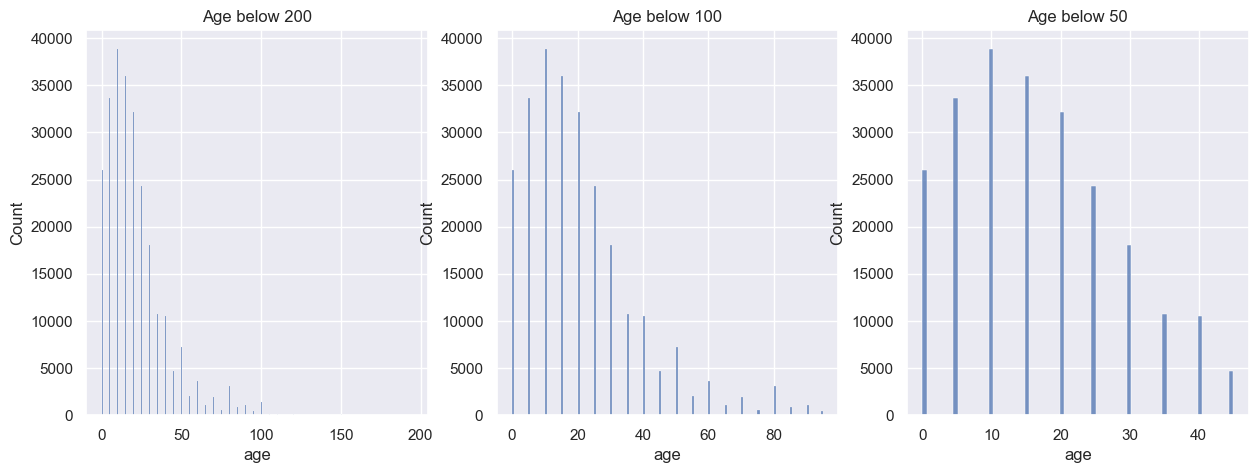

In [54]:
# as the graph shows most buildings are below the age of 200
# lets remove outliers and create a new graph

# merge the two dataframes on building_id
merged_df = pd.merge(train_df, target_df, on='building_id')

threshold1 = 200
threshold2 = 100
threshold3 = 50

temp_df1 = merged_df[merged_df['age'] < threshold1]
temp_df2 = merged_df[merged_df['age'] < threshold2]
temp_df3 = merged_df[merged_df['age'] < threshold3]

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first graph in the first subplot
sns.histplot(temp_df1['age'], ax=axs[0])
axs[0].set_title(f'Age below {threshold1}')

# Plot the second graph in the second subplot
sns.histplot(temp_df2['age'], ax=axs[1])
axs[1].set_title(f'Age below {threshold2}')

# Plot the third graph in the third subplot
sns.histplot(temp_df3['age'], ax=axs[2])
axs[2].set_title(f'Age below {threshold3}')

plt.show()

In [10]:
target_df.head(10)

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
5,333020,2
6,728451,3
7,475515,1
8,441126,2
9,989500,1


### Analysis of the distribution of individual features

### Analysis of missing and default values, as well as finding uninformative columns

### Analysis of relationships between features

### Analysis of relationships of features to target

### Conclusions